In [ ]:
import os
import numpy as np
import pyedflib
from scipy.stats import zscore
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ⚙️ 기본 설정
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"
seq_len = 10
batch_size = 16
epochs = 50
learning_rate = 0.0001

label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}

In [15]:
# 1️⃣ 데이터 로드 함수
def load_ecg_and_labels(sn_id, root_dir):
    base = f"SN{int(sn_id):03d}"
    ecg_path = os.path.join(root_dir, f"{base}.edf")
    label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
    
    if not os.path.exists(ecg_path) or not os.path.exists(label_path):
        print(f"❌ 파일 없음: {base}")
        return [], []

    with pyedflib.EdfReader(ecg_path) as ecg_reader:
        ecg_signal = ecg_reader.readSignal(7)

    with pyedflib.EdfReader(label_path) as label_reader:
        onsets, durations, labels = label_reader.readAnnotations()

    segments, segment_labels = [], []

    for onset, duration, label in zip(onsets, durations, labels):
        label_str = label.decode() if isinstance(label, bytes) else label
        if label_str not in label_map:
            continue

        start = int(onset * 256)
        num_segments = int(duration // 30)

        for i in range(num_segments):
            seg_start = start + i * 7680
            seg_end = seg_start + 7680
            if seg_end > len(ecg_signal):
                break

            segment = zscore(ecg_signal[seg_start:seg_end])
            if np.isnan(segment).any():
                continue
            segments.append(segment.astype(np.float32))
            segment_labels.append(label_map[label_str])

    return segments, segment_labels

def create_sequences(segments, labels, seq_len=10):
    X, y = [], []
    for i in range(len(segments) - seq_len + 1):
        X.append(np.stack(segments[i:i+seq_len]))
        y.append(labels[i + seq_len - 1])
    return np.array(X), np.array(y)

def merge_data(data_dict):
    X_all, y_all = [], []
    for X, y in data_dict.values():
        if len(X) == 0:
            continue
        X_all.append(X)
        y_all.append(y)
    if len(X_all) == 0:
        return np.array([]), np.array([])  # 비어있을 때 처리
    return np.concatenate(X_all), np.concatenate(y_all)


In [16]:
# 2️⃣ PyTorch Dataset
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
# 3️⃣ LSTM 모델
class SleepLSTM(nn.Module):
    def __init__(self, input_size=7680, hidden_size=128, num_layers=2, num_classes=4):
        super(SleepLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
# 4️⃣ 학습 및 평가 함수
def train_model(model, loader, epochs=50, lr=0.0001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        acc = correct / total if total > 0 else 0
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f} Acc: {acc:.4f}")

def evaluate_model(model, loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    
    # Classification Report
    print(classification_report(
        all_labels, all_preds, 
        labels=[0,1,2,3], 
        target_names=["W", "N1/2", "N3", "R"],
        zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "N1/2", "N3", "R"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


In [19]:
# 5️⃣ 데이터 로드 및 분리
train_X, train_y = [], []
val_data, test_data = {}, {}

for i in range(1, 155):
    segments, labels = load_ecg_and_labels(i, root_dir)
    if segments:
        X_seq, y_seq = create_sequences(segments, labels, seq_len)
        if 1 <= i <= 93:
            train_X.append(X_seq)
            train_y.append(y_seq)
        elif 94 <= i <= 123:
            val_data[f"SN{i:03d}"] = (X_seq, y_seq)
        else:
            test_data[f"SN{i:03d}"] = (X_seq, y_seq)

train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)
print(f"✅ Train shape: {train_X.shape}, {train_y.shape}")

❌ 파일 없음: SN014
❌ 파일 없음: SN064
❌ 파일 없음: SN135
✅ Train shape: (81795, 10, 7680), (81795,)


In [20]:
# 6️⃣ 모델 학습
train_loader = DataLoader(SleepDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
model = SleepLSTM()
train_model(model, train_loader, epochs=epochs, lr=learning_rate)

Epoch [1/10] Loss: 3185.3409 Acc: 0.7679
Epoch [2/10] Loss: 1381.7050 Acc: 0.9028
Epoch [3/10] Loss: 1084.9034 Acc: 0.9163
Epoch [4/10] Loss: 876.2222 Acc: 0.9287
Epoch [5/10] Loss: 702.7189 Acc: 0.9424
Epoch [6/10] Loss: 485.3220 Acc: 0.9636
Epoch [7/10] Loss: 297.4149 Acc: 0.9806
Epoch [8/10] Loss: 210.5361 Acc: 0.9876
Epoch [9/10] Loss: 175.9328 Acc: 0.9897
Epoch [10/10] Loss: 156.8586 Acc: 0.9911



📊 Validation (전체) 평가
              precision    recall  f1-score   support

           W       0.20      0.15      0.17      4851
        N1/2       0.47      0.61      0.53     11507
          N3       0.21      0.15      0.18      5008
           R       0.16      0.12      0.14      3633

    accuracy                           0.36     24999
   macro avg       0.26      0.26      0.25     24999
weighted avg       0.32      0.36      0.33     24999



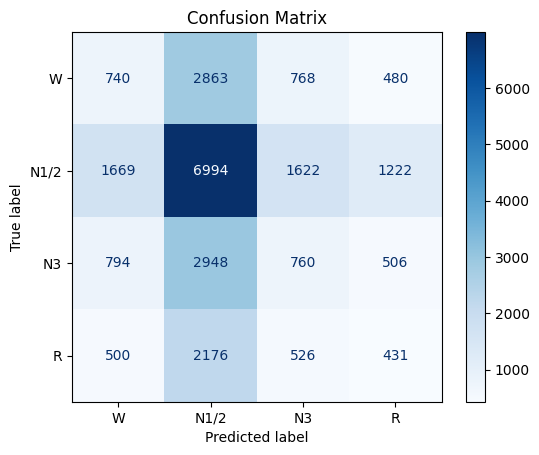


📊 Test (전체) 평가
              precision    recall  f1-score   support

           W       0.16      0.15      0.16      4228
        N1/2       0.48      0.62      0.54     13288
          N3       0.21      0.13      0.16      5803
           R       0.15      0.09      0.11      4280

    accuracy                           0.36     27599
   macro avg       0.25      0.25      0.24     27599
weighted avg       0.32      0.36      0.34     27599



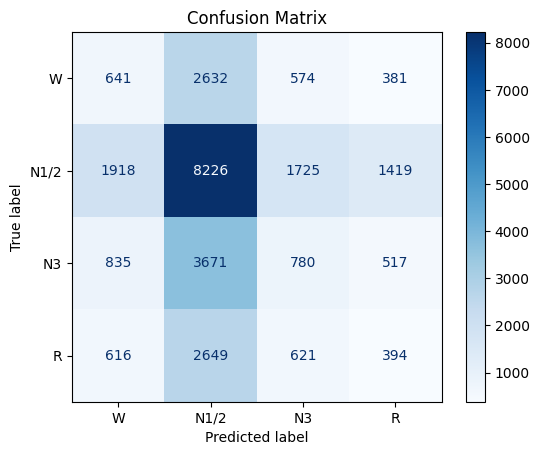

In [24]:
# 7️⃣ 전체 평가
print("\n📊 Validation (전체) 평가")
X_val_all, y_val_all = merge_data(val_data)
evaluate_model(model, DataLoader(SleepDataset(X_val_all, y_val_all), batch_size=batch_size, shuffle=False))

print("\n📊 Test (전체) 평가")
X_test_all, y_test_all = merge_data(test_data)
evaluate_model(model, DataLoader(SleepDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=False))